# Description

notebook to generate training and test sets for building mouse heart SVM model

# Setup

load r-kernel to use in the same notebook

In [ ]:
%load_ext rpy2.ipython

In [9]:
%%R

.libPaths()

[1] "/home/phan/R/x86_64-pc-linux-gnu-library/4.2"
[2] "/pkg/R-4.2.1-0/lib/R/library"                


# Prepare training data

- ATAC peaks from ENCODE and in house (mm10) for positive and neg sets.
    - Take the common intervals from all samples w bedtools multiinter before filtering

In [ ]:
%%bash

BED=../data/svm/bed

## get all common ranges from all positive & negative peaks 

bedtools multiinter -i \
"$BED"/E105H_ATAC.mm10.narrowPeak "$BED"/E115H_ATAC.mm10.narrowPeak \
$BED/ENCSR451NAE.mm10.narrowPeak \
$BED/ENCSR552ABC.mm10.narrowPeak \
$BED/ENCSR652CNN.mm10.narrowPeak \
$BED/ENCSR068YGC.mm10.narrowPeak | awk 'BEGIN{OFS="\t"} $4 > 1 {print $1, $2, $3, $4}' > $BED/pos_set_multiinter.mm10.bed


bedtools multiinter -i \
"$BED"/G4-LIF.mm10.narrowPeak \
"$BED"/ENCSR088UYE.mm10.narrowPeak \
$BED/ENCSR154BXN.mm10.narrowPeak \
$BED/ENCSR559FAJ.mm10.narrowPeak \
$BED/ENCSR302LIV.mm10.narrowPeak \
$BED/ENCSR551WBK.mm10.narrowPeak | awk 'BEGIN{OFS="\t"} $4 > 1 {print $1, $2, $3, $4}' > $BED/neg_set_multiinter.mm10.bed

[write peaks filtering and pos/neg training strategis here ...]

## Get test set & write fasta

In [ ]:
## get genome files for sequences

! twoBitToFa /project/MDL_ChIPseq/data/genome/assembly/mm10.2bit ../data/svm/fasta/mm10.genome.fa

In [18]:
%%bash
BED=../data/svm/bed
FASTA=../data/svm/fasta

# get chr1&chr2 as test set
ls $BED/*500*bed | sed -e 's/\.mm10\.bed//' \
| parallel "cat {}.mm10.bed | egrep -w 'chr1|chr2' | gzip -c > {}_test.mm10.bed.gz"

ls $BED/*500*bed | sed -e 's/\.mm10\.bed//' \
| parallel "cat {}.mm10.bed | egrep -w -v 'chr1|chr2' | gzip -c > {}_train.mm10.bed.gz"

# get fasta from bed
find $BED -name '*gz' -printf '%f\n'| \
sed -e 's/\.mm10\.bed\.gz//' | \
parallel "bedtools getfasta -fi '$FASTA'/mm10.genome.fa -bed '$BED'/{}.mm10.bed.gz > '$FASTA'/{}.mm10.fa"

# Train SVM

## Hyperparameter tuning with new training set

In [ ]:
#!/bin/bash

## script SVM_hypptuning.sh sent to mxqsub for heavy computing ##

HERE=$(realpath ..)
BED=$HERE/data/svm/bed
FASTA=$HERE/data/svm/fasta
OUT=$HERE/data/svm/txt
GKM=$HERE/code/dev/gkmexplain/lsgkm-svr/src/gkmtrain

trainP=$FASTA/pos_set_filtered_500bp_train.mm10.fa
trainN=$FASTA/neg_set_GCR-matched_500bp_train.mm10.fa

# Define the arrays of c & g
c=(20 10 5 1)
g=(5 2 1 0.1)

mxqsub --stderr=_logs/gkmtrain_5cv_t3_hpptuning.stderr --group-name=gkmtrain --threads=64 --memory=100G --tmpdir=20G -t 1440 \
parallel -j 4  -v " '$GKM' -T 16 -t 3 -c {1} -g {2} -x5 -i 1 '$trainP' '$trainN' '$OUT'/lsgkm_kernel3_500_c{1}_g{2} > ./_logs/train_t3_500_c{1}_g{2}.log" ::: "${c[@]}" ::: "${g[@]} "

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## wrappers to get AUC scores from cross-validation output
def get_scores(cvpred, label):
    scores = []
    with open(cvpred, 'r') as f:
        for line in f:
            fields = line.strip().split('\t')
            if label == 'pos' and fields[2] == '1':
                scores.append(float(fields[1]))
            elif label == 'neg' and fields[2] == '-1':
                scores.append(float(fields[1]))
    return scores


def roc_auc_wrapper(cvpred):
    pos_preds = get_scores(cvpred, label = 'pos')                      
    neg_preds = get_scores(cvpred, label = 'neg')
    
    labels = [1 for x in pos_preds]+[0 for x in neg_preds]
    auc = roc_auc_score(y_true=labels, y_score = pos_preds+neg_preds)
    return auc

In [9]:
# List of 'c' and 'g' values
c_values = [1, 5, 10, 20]
g_values = [0, 1, 2, 5]

# Dictionary to store the computed scores
score_dict = {}

# Compute ROC AUC score for each 'c' and 'g' pair
for c in c_values:
    for g in g_values:
        cvpred_file = f"../data/svm/txt/lsgkm_kernel3_500_c{c}_g{g}.cvpred.1.txt"
        score = roc_auc_wrapper(cvpred_file)
        score_dict[(c, g)] = score

# Create a matrix of scores for heatmap
score_matrix = []
for c in c_values:
    row = [score_dict[(c, g)] for g in g_values]
    score_matrix.append(row)

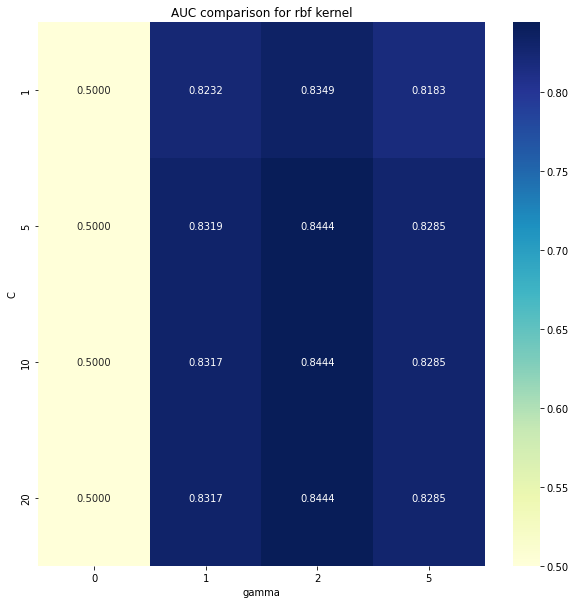

In [12]:
# Plot heatmap
plt.figure(figsize=(10,10))

sns.heatmap(score_matrix, annot=True, fmt=".4f", cmap="YlGnBu",
            xticklabels=g_values, yticklabels=c_values)


plt.xlabel("gamma")
plt.ylabel("C")
plt.title("AUC comparison for rbf kernel")
plt.savefig('../figures/AUC_grid_cv5_rbf_c_gamma.pdf', dpi=300, transparent=True)
plt.show()

## Training SVM
From grid-search, move on with c=10 & gamma=2

In [ ]:
%%bash

HERE=$(realpath ..)
FASTA=$HERE/data/svm/fasta
OUT=$HERE/data/svm/
GKM=$HERE/code/dev/gkmexplain/lsgkm-svr/src/gkmtrain


[[ -e $OUT/lsgkm_rbf_c10_g2.model.txt ]] || \
$GKM -v 1 -T 16 -t 3 -c 10 -g 2 $FASTA/pos_set_filtered_500bp_train.mm10.fa $FASTA/neg_set_GCR-matched_500bp_train.mm10.fa $OUT/lsgkm_rbf_c10_g2

## Model eval on held out chroms

In [ ]:
%%bash

HERE=$(realpath ..)
FASTA=$HERE/data/svm/fasta
OUT=$HERE/data/svm/txt
GKM=$HERE/code/dev/gkmexplain/lsgkm-svr/src/gkmpredict
MODEL=$HERE/data/svm/lsgkm_rbf_c10_g2.model.txt

[[ -e $OUT/test_rbf_c10_g2_pos.txt ]] || $GKM -T 16 $FASTA/pos_set_filtered_500bp_test.mm10.fa $MODEL  $OUT/test_rbf_c10_g2_pos.txt
[[ -e $OUT/test_rbf_c10_g2_neg.txt ]] || $GKM -T 16 $FASTA/neg_set_GCR-matched_500bp_test.mm10.fa $MODEL  $OUT/test_rbf_c10_g2_neg.txt

### weighted RBF

In [ ]:
%%bash

HERE=$(realpath ..)
FASTA=$HERE/data/svm/fasta
OUT=$HERE/data/svm/txt
GKM=$HERE/code/dev/gkmexplain/lsgkm-svr/src/gkmpredict
MODEL=$HERE/data/svm/lsgkm_wrbf_c10_g2.model.txt

[[ -e $OUT/test_wrbf_c10_g2_pos.txt ]] || $GKM -T 16 $FASTA/pos_set_filtered_500bp_test.mm10.fa $MODEL  $OUT/test_wrbf_c10_g2_pos.txt
[[ -e $OUT/test_wrbf_c10_g2_neg.txt ]] || $GKM -T 16 $FASTA/neg_set_GCR-matched_500bp_test.mm10.fa $MODEL  $OUT/test_wrbf_c10_g2_neg.txt

In [2]:
from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, average_precision_score
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def plot_roc2(sample_name):
    # Define file paths based on sample_name
    pos_file = f"../data/svm/txt/{sample_name}_pos.txt"
    neg_file = f"../data/svm/txt/{sample_name}_neg.txt"
    
    # Read data from files
    pos_preds = [float(x.rstrip().split("\t")[1]) for x in open(pos_file)]
    neg_preds = [float(x.rstrip().split("\t")[1]) for x in open(neg_file)]
    
    # Generate labels
    labels = [1] * len(pos_preds) + [0] * len(neg_preds)
    
    # Concatenate predictions
    #y_pred = pos_preds + neg_preds
    
    # Create ROC curve
    #fpr, tpr, _ = roc_curve(labels, y_pred)
    ax=plt.gca()
    
    RocCurveDisplay.from_predictions(y_true = labels, 
                                    y_pred =  pos_preds + neg_preds,
                                    name = sample_name, ax=ax)
    
    # Assign color from seaborn palette
    #color = sns.color_palette(palette_name)[len(os.listdir("../data/svm/txt")) - 1]
    
    # Plot ROC curve
    #plt.plot(fpr, tpr, label=sample_name)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

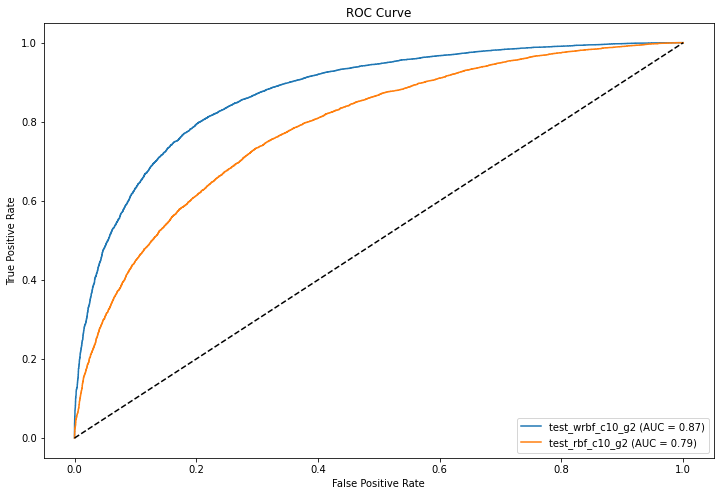

In [6]:
plt.figure(figsize=(12, 8))
plot_roc2("test_wrbf_c10_g2")
plot_roc2("test_rbf_c10_g2")
plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.savefig('../figures/SVM_test_held-out_chrom_mmus.pdf', dpi = 300)
plt.show()